In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

**데이터 설명**
- Frequency
    - None: 광고 노출 X
    - 7:1: 7번의 비광고 컨텐츠 이후 1번의 광고
    - 4:1: 4번의 비광고 컨텐츠 이후 1번의 광고
    - 1:1: 1번의 비광고 컨텐츠 이후 1번의 광고
- Type
    - 1: Photo
    - 2: Video
- Time
    - 세션 지속 시간 (분)
    


- 광고가 사용자 참여에 미치는 영향을 평가
    - 독립변수: 광고
    - 종속변수: 세션 지속 시간
    - 세션 지속 시간이 짧아지면, 사용자의 이탈을 의미. 광고가 사용자 경험에 방해를 줬을 가능성.

# DATA

In [5]:
ad_data = pd.read_csv('data.csv')
print(ad_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time       8000 non-null   float64
 1   Frequency  8000 non-null   int64  
 2   Type       8000 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 187.6 KB
None


In [6]:
y = ad_data['Time']
X = ad_data[['Frequency', 'Type']]

In [14]:
groupby = ad_data.groupby(['Type','Frequency'])
desc = pd.concat([groupby.mean(), groupby.std(), groupby.skew(), groupby.count()], axis=1)
desc.columns = ['Mean','Stddev','Skew', 'N']
desc

Mean    Stddev      Skew     N
Type Frequency                                    
1    0          6.977854  0.981844 -0.062754  1000
     1          5.008560  0.967867 -0.045426  1000
     2          3.975815  0.992494 -0.012975  1000
     3          1.019292  0.466819  0.182382  1000
2    0          7.087786  0.986567 -0.038801  1000
     1          5.636176  1.035458 -0.106518  1000
     2          4.834985  0.992751 -0.022929  1000
     3          1.476534  0.494478  0.132331  1000

In [17]:
groupby = ad_data.groupby(['Type','Frequency'])
groupby.describe()

Time                                                    \
                 count      mean       std       min       25%       50%   
Type Frequency                                                             
1    0          1000.0  6.977854  0.981844  3.316368  6.325213  6.998485   
     1          1000.0  5.008560  0.967867  2.091807  4.350080  5.001010   
     2          1000.0  3.975815  0.992494  0.265583  3.333472  3.976653   
     3          1000.0  1.019292  0.466819  0.001670  0.690710  1.019757   
2    0          1000.0  7.087786  0.986567  3.423597  6.427691  7.053530   
     1          1000.0  5.636176  1.035458  1.908586  4.975725  5.662465   
     2          1000.0  4.834985  0.992751  2.227462  4.127440  4.833080   
     3          1000.0  1.476534  0.494478  0.123407  1.135917  1.459891   

                                     
                     75%        max  
Type Frequency                       
1    0          7.642555   9.810173  
     1          5.701712   8.275155  
     2          4.612711   6.954104  
     3          1.323191   2.880799  
2    0          7.807231   9.968257  
     1          6.320784  10.069342  
     2          5.549537   7.759778  
     3          1.805565   3.284424

In [19]:
level1 = ad_data['Frequency'].unique()
level2 = ad_data['Type'].unique()

# Visualize

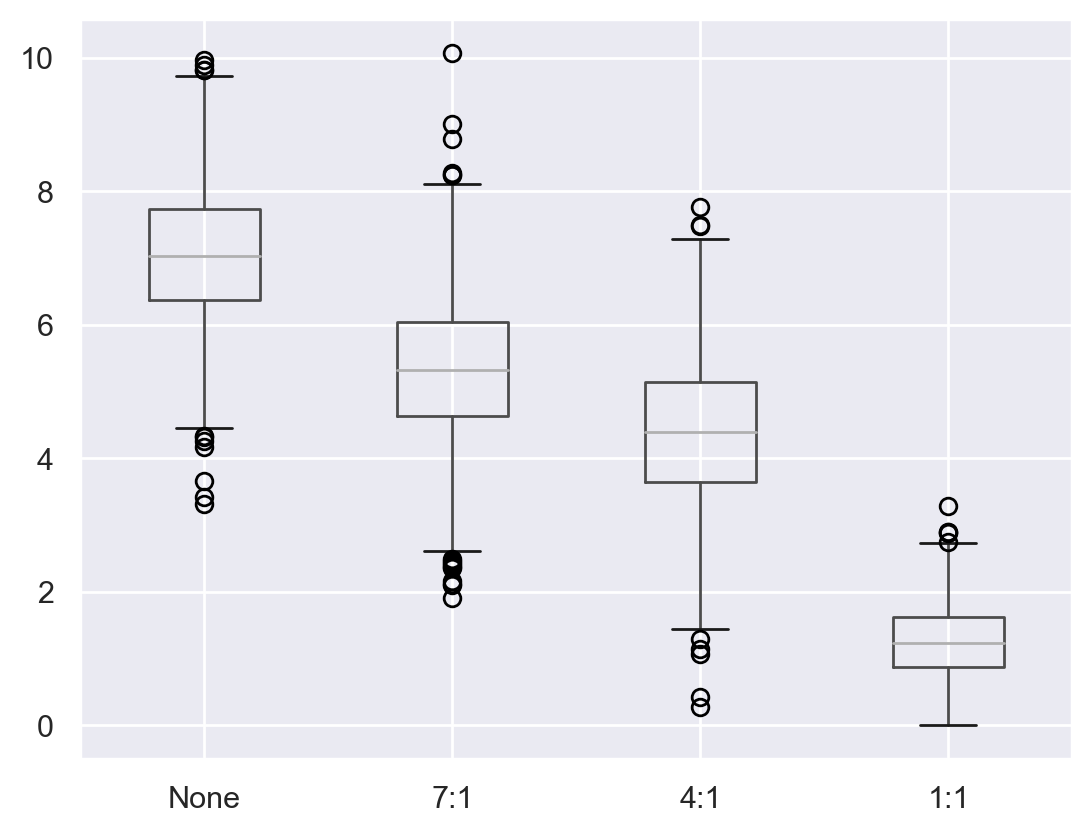

In [27]:
f1 = pd.concat([ad_data[ad_data['Frequency'] == i ]['Time'].reset_index(drop=True) for i in level1 ], axis=1)
f1.columns = ['None','7:1','4:1','1:1']
f1.boxplot()
plt.show()

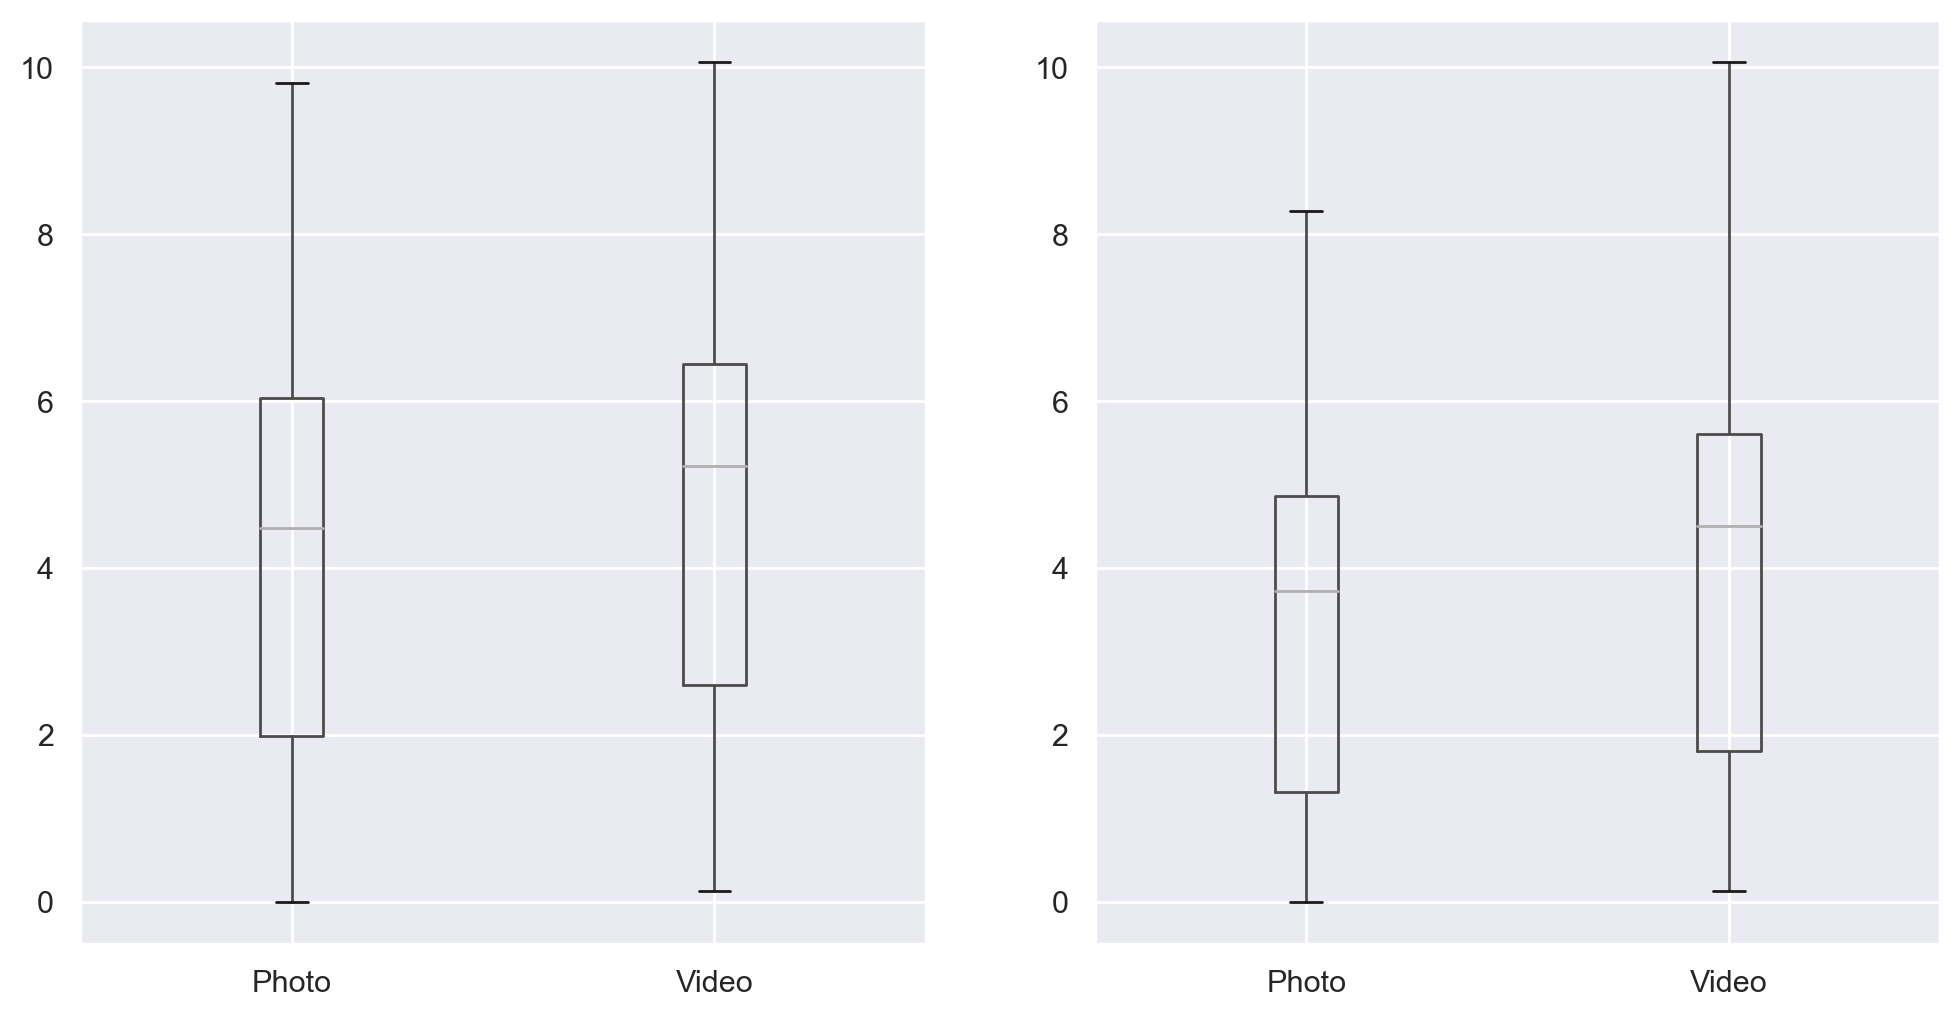

In [33]:
f2a = pd.concat([ad_data[ad_data['Type'] == i]['Time'].reset_index(drop=True) for i in level2], axis=1 )
f2a.columns = ['Photo','Video']

ad_data2 = ad_data[ad_data['Frequency'] != 0].reset_index(drop=True)
f2b = pd.concat([ad_data2[ad_data2['Type'] == i]['Time'].reset_index(drop=True) for i in level2], axis=1 )
f2b.columns = ['Photo','Video']

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
f2a.boxplot()
plt.subplot(1, 2, 2)
f2b.boxplot()
plt.show()

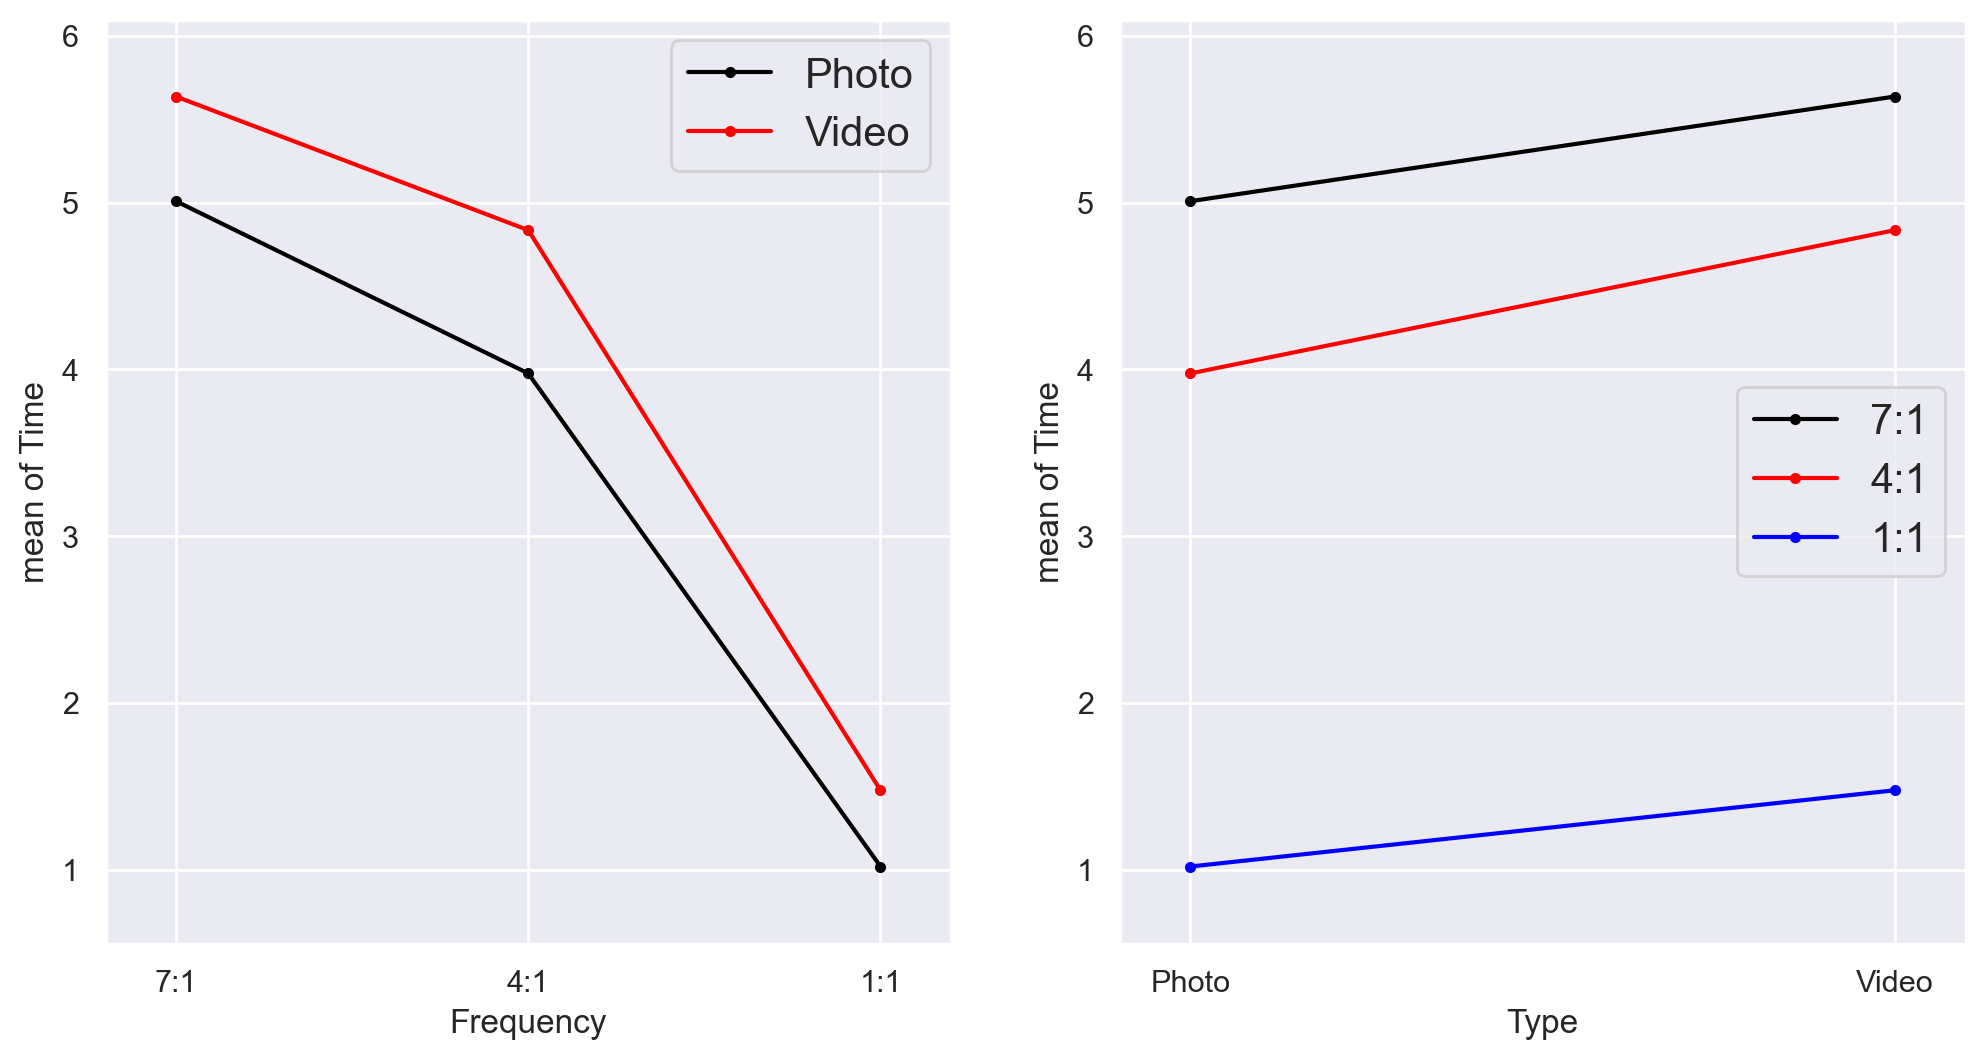

In [34]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
interaction_plot(x=ad_data2['Frequency'], trace=ad_data2['Type'],
                response=ad_data2['Time'], colors=['black','red'], ax=ax1)
plt.xticks([1, 2, 3], ['7:1','4:1','1:1'])
plt.xlabel(xlabel='Frequency')
plt.legend(['Photo','Video'], fontsize=15)

ax2 = plt.subplot(1, 2, 2)
interaction_plot(x=ad_data2['Type'], trace=ad_data2['Frequency'],
                response=ad_data2['Time'], colors=['black','red','blue'], ax=ax2)
plt.xticks([1, 2], ['Photo','Video'])
plt.xlabel(xlabel='Type')
plt.legend(['7:1','4:1','1:1'], fontsize=15)
plt.show()


# 회귀분석

$$ Y = \beta_0 + \beta_1 x_{11} + \beta_2 x_{21} + \beta_3 x_{22} + \beta_4 x_{11} x_{21} + \beta_5 x_{11} x_{22} + \epsilon $$


- $Y$: 종속 변수 (duration)
- $\beta_0$: 절편
- $x_{11}$: 광고 유형 인디케이터 (0 or 1)
- $x_{21}, x_{22}$: 광고 빈도 수준(=level)
- $\beta_1, \beta_2, \beta_3$: 요인에 대한 main effect
- $x_{11} x_{21}$: 교차항. 광고 유형과 광고 빈도가 종속변수에 미치는 영향
- Contrast Coding

In [47]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(X)
oh_encoded = encoder.transform(X).toarray()
oh_encoded

array([[1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 0., 1.]])

In [59]:
ols = sm.OLS.from_formula('Time ~ C(Frequency) * C(Type)', data=ad_data2)
fitted = ols.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Time   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     5118.
Date:                Thu, 24 Oct 2024   Prob (F-statistic):               0.00
Time:                        14:13:44   Log-Likelihood:                -7608.6
No. Observations:                6000   AIC:                         1.523e+04
Df Residuals:                    5994   BIC:                         1.527e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          5.0086      0.027    184.078      0.000       4.955       5.062
C(Frequency)[T.2]                 -1.0327      0.038    -26.839      0.000      -1.108      -0.957
C(Frequency)[T.3]                 -3.9893      0.038   -103.673      0.000      -4.065      -3.914
C(Type)[T.2]                       0.6276      0.038     16.310      0.000       0.552       0.703
C(Frequency)[T.2]:C(Type)[T.2]     0.2316      0.054      4.255      0.000       0.125       0.338
C(Frequency)[T.3]:C(Type)[T.2]    -0.1704      0.054     -3.131      0.002      -0.277      -0.064
==============================================================================
Omnibus:                       77.883   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.624
Skew:                          -0.042   Prob(JB):                     7.91e-31
Kurtosis:                       3.740   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

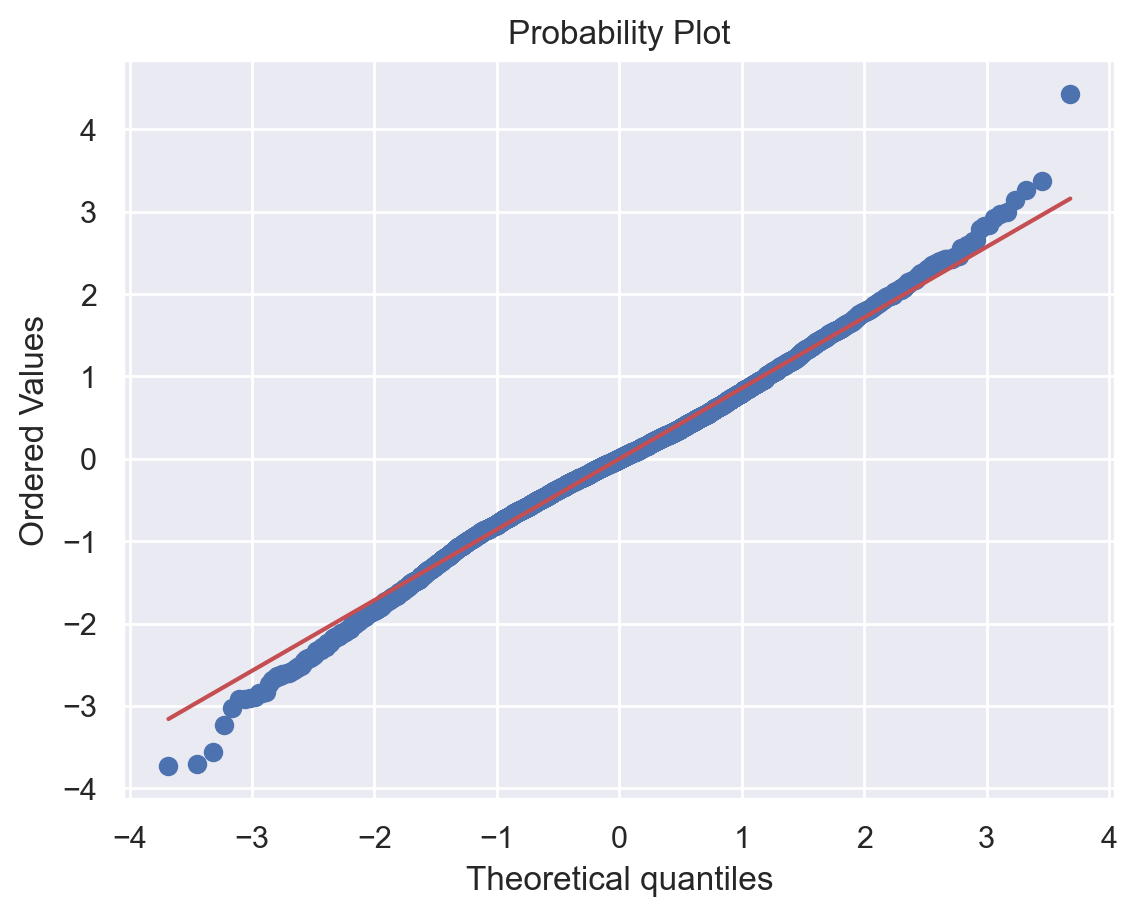

In [60]:
stats.probplot(fitted.resid, plot=plt)
plt.show()

In [61]:
# H0: it follows normal
stat, p = stats.shapiro(fitted.resid)
print(stat, p)

0.9946308732032776 3.407108715167487e-14


C:\Users\Hobin\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1761: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [63]:
stat, p = stats.levene(fitted.resid, fitted.fittedvalues)
print(stat, p)

2413.5757818478596 0.0


# ANOVA

- Main Effects
    - Frequency
        - H0: 광고 빈도의 각 수준에 따른 세션 지속 시간의 평균 차이가 없다.
        - H1: 광고 빈도의 각 수준에 따른 세션 지속 시간의 평균 차이가 있다.
    - Type
        - H0: 광고 유형에 따른 세션 지속 시간의 평균 차이가 없다.
        - H1: 광고 유형에 따른 세션 지속 시간의 평균 차이가 있다.
- Interaction
    - H0: 광고 빈도와 광고 유형 간의 상호작용이 없다.
    - H1: 광고 빈도와 광고 유형 간의 상호작용이 있다.

- 보통 상호작용 효과먼저 점검하는 것이 좋음. 상호작용 term이 존재하면, main effect도 조건부로 해석을 해야하기 때문

$$ MSA = \frac{SS_A}{df_A} $$


$$ SS_A = \sum_{i=1}^k n_i (\bar{Y}_i  - \bar{Y}) $$


$$ SS_E = \sum_{i=1}^k \sum_{j=1}^{n_i}  (Y_{ij}  - \bar{Y}_i) $$

$$ F = \frac{mean \; square \; between \; factor \; A}{MSE} $$

$$ F = \frac{mean \; square \; between \; factor \; B}{MSE} $$

$$ F = \frac{mean \; square \; between \; factor \; AB}{MSE} $$

In [64]:
ols = sm.OLS.from_formula('Time ~ C(Frequency) * C(Type)', data=ad_data2)
fitted = ols.fit()
sm.stats.anova_lm(fitted)

,df,sum_sq,mean_sq,F,PR(>F)
C(Frequency),2.0,18274.493775,9137.246887,12342.159896,0.000000e+00
C(Type),1.0,629.874166,629.874166,850.804160,5.074446e-175
C(Frequency):C(Type),2.0,40.698425,20.349212,27.486751,1.309376e-12
Residual,5994.0,4437.526195,0.740328,NaN,NaN
